## Analysis of Wine Reviews
### Data sourced from Kaggle (Dataset: [Wine Reviews](https://www.kaggle.com/datasets/zynicide/wine-reviews/data))

Data consists of nearly 130,000 records of reviews consisting of the following fields:

- country: Country of origin
- description: Body of review
- designation: Vineyard from which wine grapes were sourced
- points: Wine Enthusiast score (scale 1-100) 
- price: Retail price per bottle
- province: Province or state of origin
- region_1: Region of origin
- region_2: Appelation or sub-region of origin (if specified)
- taster_name: Name of reviewer
- taster_twitter_handle: Twitter handle of reviewer
- title: Title of review, including winery, vintage, variety, and region or country of origin
- variety: Variety of grape used, includes both general and specific descriptions of blends (e.g. "White Blend", "Bordeaux style red blend", or "Tempranillo-Merlot")
- winery: Winery which produced the reviewed wine


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import scipy
import warnings


In [2]:
# Notebook settings
warnings.filterwarnings('ignore')
sns.set_palette('pastel')

In [3]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('winemag-data-130k-v2.csv', encoding='utf-8', index_col=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


***
### Dataset preparation
Dataset does not include a column for the Vintage of each wine. Vintage can be observed in the 'title' field of each record. A discrete column for vintage can then be created by extracting the vintage from the title of the wine.



In [4]:
null_vintages = 0
for row in df.title.index:
    try:
        vintage = re.search(r'20[0-2][0-9]', df.title[row]).group()
        df.loc[row,'vintage'] = vintage
        # print( vintage)
    except AttributeError as e:
        null_vintages += 1
print(null_vintages)

df[['title', 'vintage']].head()

6345


,title,vintage
0,Nicosia 2013 Vulkà Bianco (Etna),2013
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),2011
2,Rainstorm 2013 Pinot Gris (Willamette Valley),2013
3,St. Julian 2013 Reserve Late Harvest Riesling ...,2013
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,2012


Fields created to discretize wines by points and price

In [5]:
point_bins = ['{0}-{1}'.format(i, i+1) for i in range(80, 100, 2)]
price_bins = ['${0}-{1}']
df['point_range'] = pd.cut(df.points, range(80,102,2), right=True, labels=point_bins)
df[['points', 'point_range']]

,points,point_range
0,87,86-87
1,87,86-87
2,87,86-87
3,87,86-87
4,87,86-87
...,...,...
129966,90,88-89
129967,90,88-89
129968,90,88-89
129969,90,88-89


In [6]:
df['price_category'] = pd.cut(df.price, bins=[0, 10, 20,30, 45, 60, 75, 90, np.inf], labels=['Under 10',' 11-20', '21-30', '31-45', '46-60', '61-75', '76-90', 'Over 90'])
df[['price', 'price_category']].head(10)

,price,price_category
0,NaN,NaN
1,15.0,11-20
2,14.0,11-20
3,13.0,11-20
4,65.0,61-75
5,15.0,11-20
6,16.0,11-20
7,24.0,21-30
8,12.0,11-20
9,27.0,21-30


"Value score" will be calculated as points divided by price, using points as a proxy for quality to represent the quality of the wine by price per bottle.

To avoid bias cuased by wines with excessively low or high prices, value score will only be discretized into value categories within the middle 50% of wines by price.

Wines below the 25th percentile ($17) will be considered "Bargain" wines, while those above the 75th percentile will be considered "Luxury" Wines.

In [7]:
df['value_score'] = df['points']/df['price']
df['value_score'].describe()


count    120975.000000
mean          3.840562
std           2.216740
min           0.026667
25%           2.119048
50%           3.458333
75%           5.117647
max          21.500000
Name: value_score, dtype: float64

In [8]:

value_bins = ['Low Value to Price', 'Moderate Value',  'Value Buy']

middle_half = df.loc[(df['price'] >= 10) & (df['price'] < 91)]

outer_half = df.loc[(df['price'] < 10) | (df['price'] >= 91)]

middle_half['value_category'] = pd.cut(middle_half['value_score'], bins=range(0, 8, 2), right=True, labels=value_bins)
outer_half.loc[outer_half['price'] < 17, 'value_category'] = 'Bargain'
outer_half.loc[outer_half['price'] >= 91, 'value_category'] = 'Luxury'

df = pd.concat([middle_half, outer_half])

df[['price', 'value_score', 'value_category']].head(10)


,price,value_score,value_category
1,15.0,5.800000,Value Buy
2,14.0,6.214286,NaN
3,13.0,6.692308,NaN
4,65.0,1.338462,Low Value to Price
5,15.0,5.800000,Value Buy
6,16.0,5.437500,Value Buy
7,24.0,3.625000,Moderate Value
8,12.0,7.250000,NaN
9,27.0,3.222222,Moderate Value
10,19.0,4.578947,Value Buy


In [9]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 120975 entries, 1 to 129931
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   country                120916 non-null  object  
 1   description            120975 non-null  object  
 2   designation            86196 non-null   object  
 3   points                 120975 non-null  int64   
 4   price                  120975 non-null  float64 
 5   province               120916 non-null  object  
 6   region_1               101400 non-null  object  
 7   region_2               50292 non-null   object  
 8   taster_name            96479 non-null   object  
 9   taster_twitter_handle  91559 non-null   object  
 10  title                  120975 non-null  object  
 11  variety                120974 non-null  object  
 12  winery                 120975 non-null  object  
 13  vintage                115155 non-null  object  
 14  point_range            12

,points,price,value_score
count,120975.000000,120975.000000,120975.000000
mean,88.421881,35.363389,3.840562
std,3.044508,41.022218,2.216740
min,80.000000,4.000000,0.026667
25%,86.000000,17.000000,2.119048
50%,88.000000,25.000000,3.458333
75%,91.000000,42.000000,5.117647
max,100.000000,3300.000000,21.500000


***
## Wines by Price


<Axes: xlabel='price_category', ylabel='Count'>

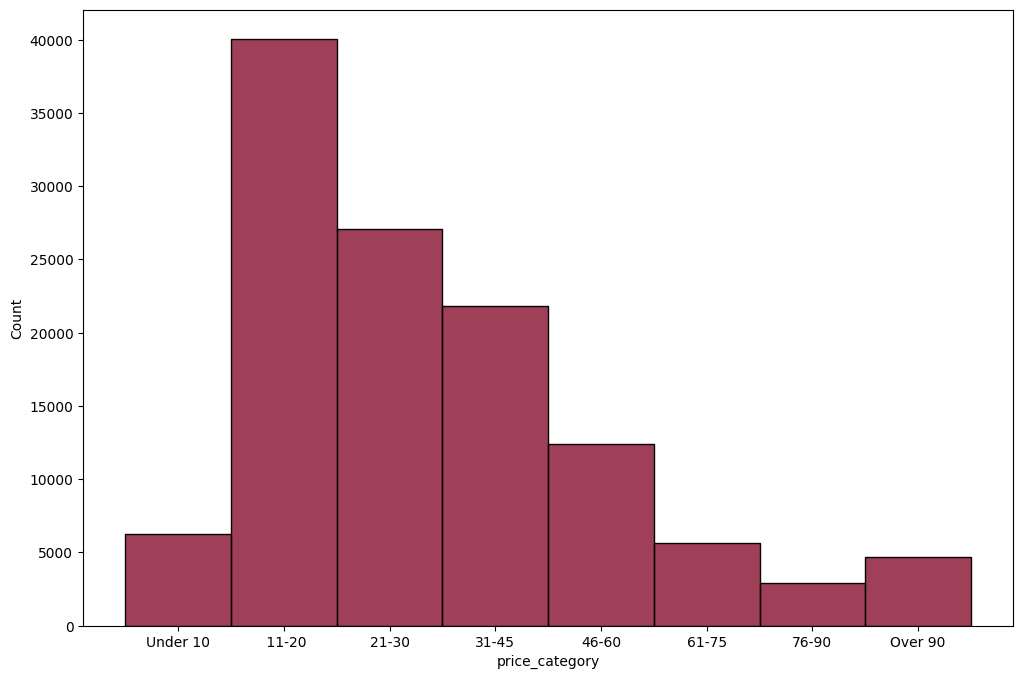

In [10]:
plt.subplots(figsize=(12, 8))
sns.histplot(df['price_category'], color='#800020')

## Wines by Score
Using score as a proxy for quality, we can observe the distribution of wines in the dataset by quality. 

(79.0, 100.0)

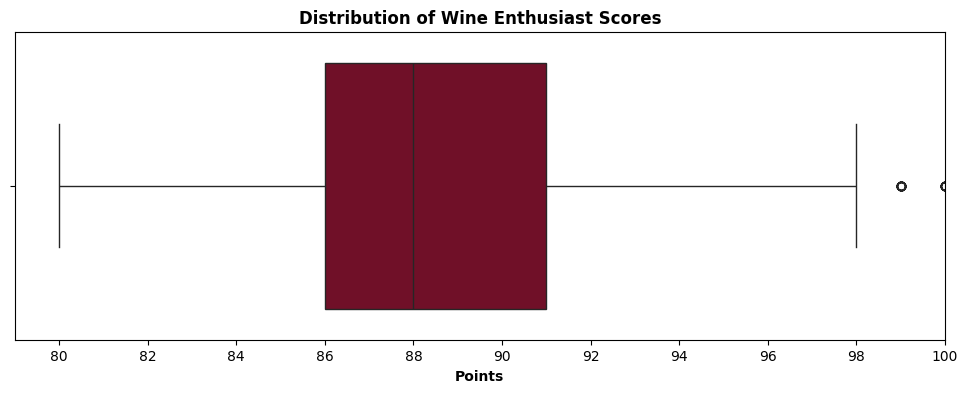

In [11]:
plt.subplots(figsize=(12, 4))
plt.title('Distribution of Wine Enthusiast Scores').set_fontweight('semibold')
plt.xlabel('Points').set_fontweight('semibold')
plt.xticks(range(80, 101, 2))
sns.boxplot(df, x=df.points, color='#800020').set_xlim(79,100)

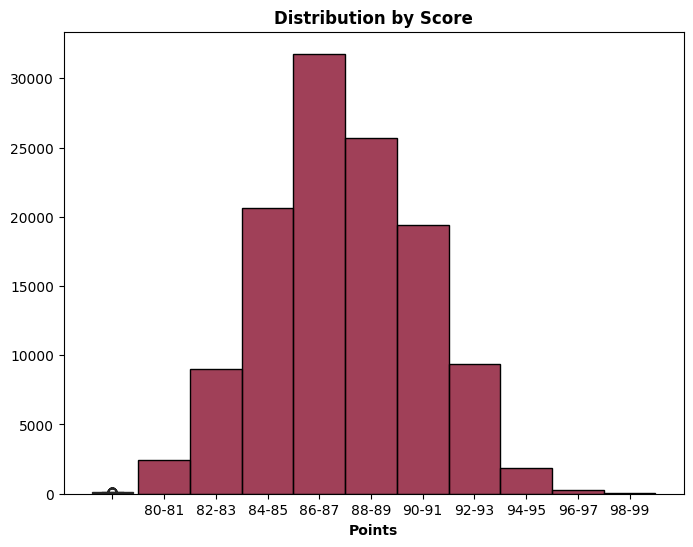

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(df, y='points', color='#800020')
sns.histplot(df, x=df.point_range, color='#800020', orientation='horizontal')
plt.title(label='Distribution by Score').set_fontweight('bold')
plt.xlabel('Points').set_fontweight('semibold')
plt.ylabel(None)
plt.show()


Text(0, 0.5, '')

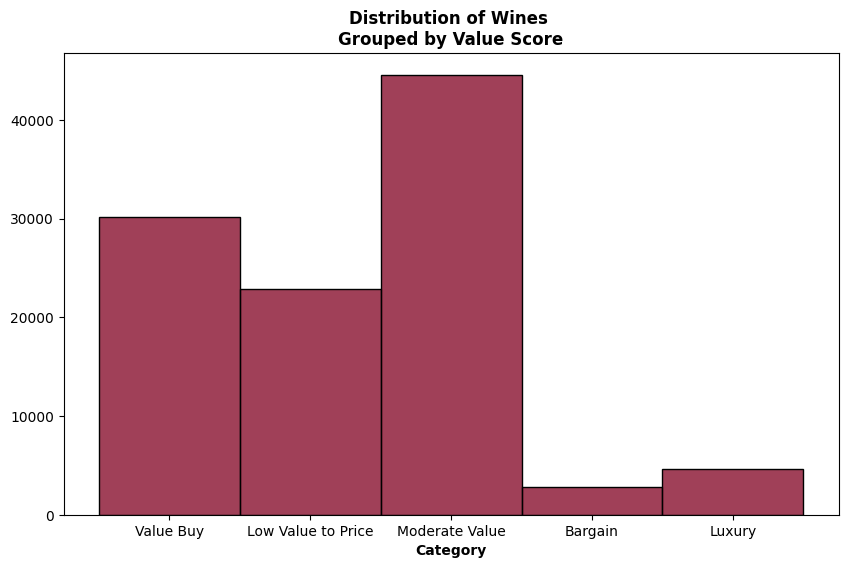

In [13]:
plt.subplots(figsize=(10, 6))
plt.title('Distribution of Wines \nGrouped by Value Score').set_fontweight('semibold')
plt.xlabel('Category').set_fontweight('semibold')

sns.histplot(df, x=df.value_category, color='#800020').set_ylabel("")


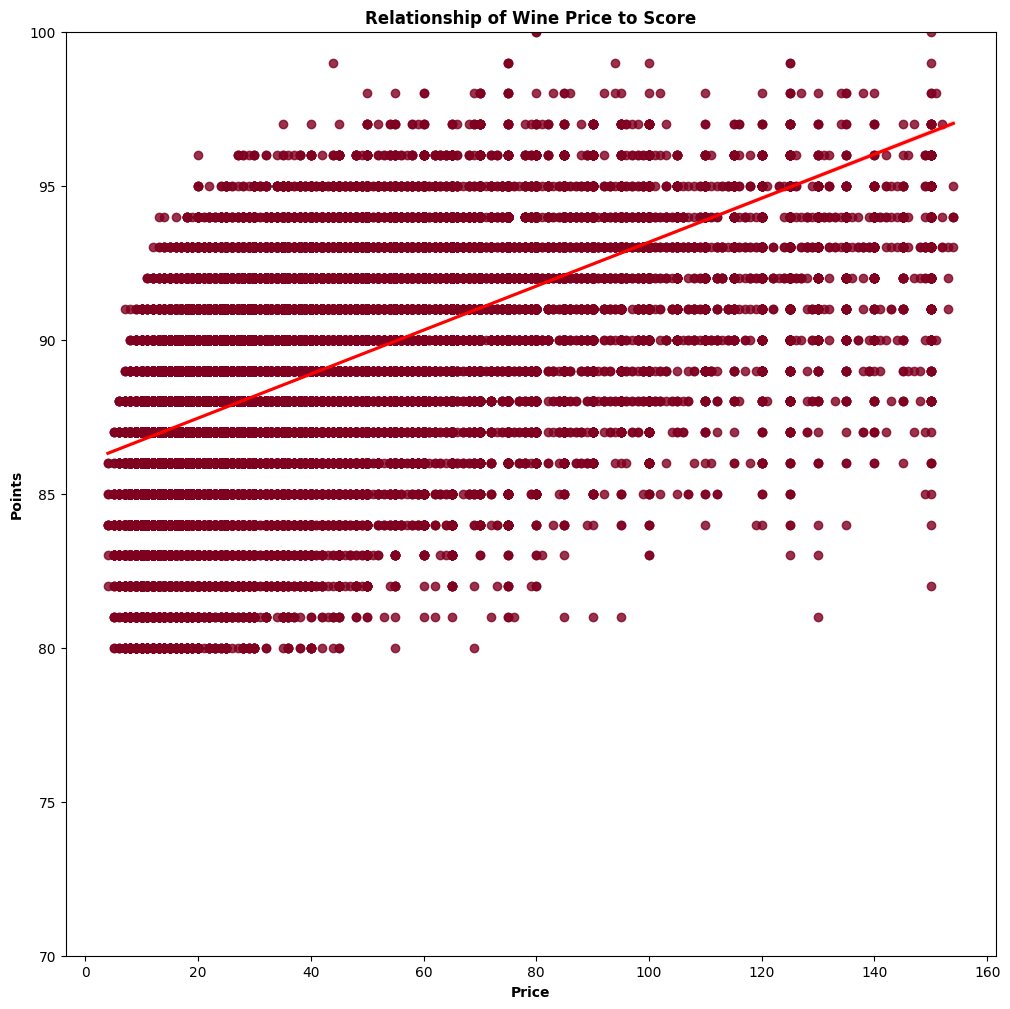

In [14]:
price99q = df.price.quantile(.99)
price05q = df.price.quantile(.05)

plt.subplots(figsize=(12,12))

price_regplot = sns.regplot(data=df.loc[df.price < price99q], x='price', y='points', color='#800020', line_kws={'color':'red'})
plt.title(label='Relationship of Wine Price to Score').set_fontweight('bold')
plt.xlabel('Price').set_fontweight('semibold')
plt.ylabel('Points').set_fontweight('semibold')

# plt.xlim(0,price99q)
plt.ylim(70,100)
plt.show()



In [15]:

import scipy.stats

fitline = [(x,y) for x,y in zip(price_regplot.get_lines()[0].get_xdata(),price_regplot.get_lines()[0].get_ydata())]
price_product_line = scipy.stats.linregress(fitline)

print(f'On average among the bottom 99% of wines, for every dollar more a wine is priced correlates to a higher Wine Enthusiast score by {round(float(price_product_line.slope),2)}') 


On average among the bottom 99% of wines, for every dollar more a wine is priced correlates to a higher Wine Enthusiast score by 0.07


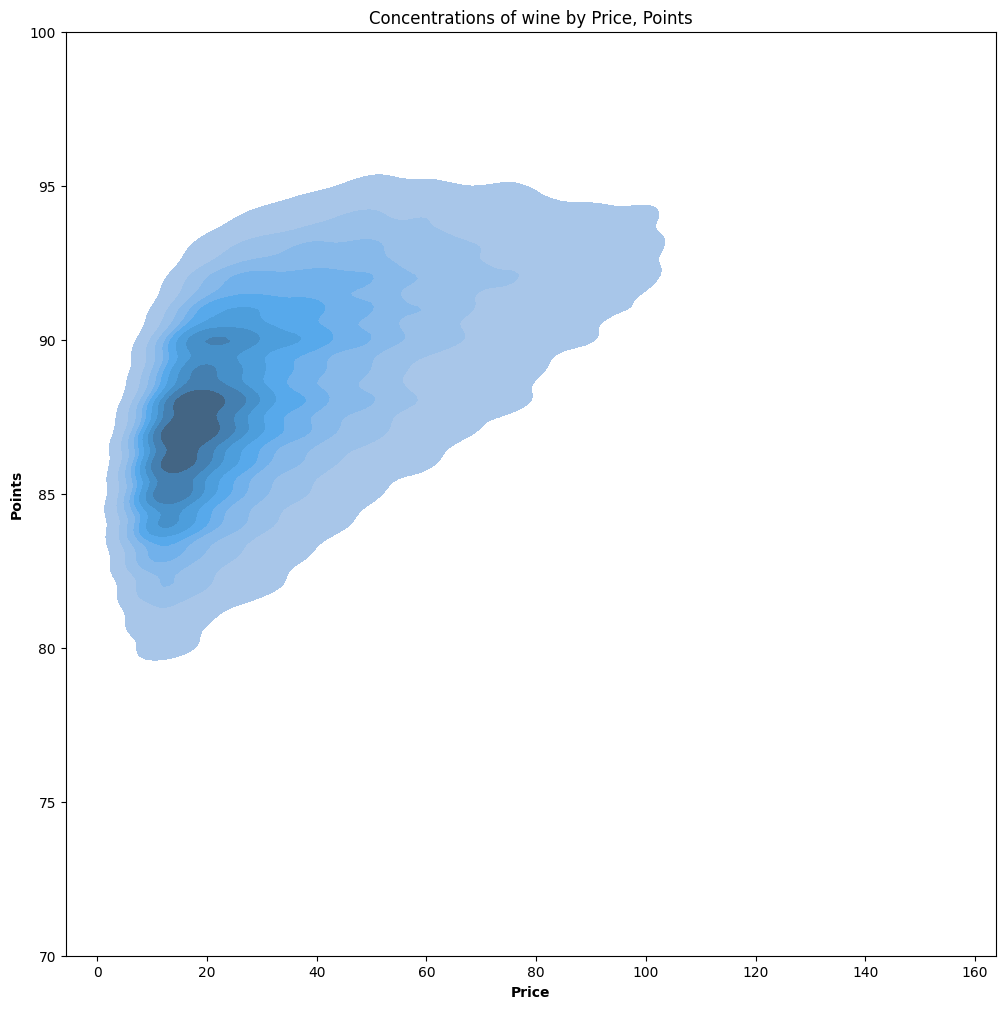

In [16]:
subset = df.loc[(df['price']< price99q)]
plt.subplots(figsize=(12,12))
sns.kdeplot( data=subset, x=subset.price, y=subset.points, palette='pastel', fill=True)
plt.xlabel('Price').set_fontweight('semibold')
plt.ylabel('Points').set_fontweight('semibold')
plt.title('Concentrations of wine by Price, Points')
price95q = df.price.quantile(.95)

plt.ylim(70,100)
plt.show()


Within the bottom 99% of wines, higher priced wines tend to score higher, here we observe the distribution of wines by price and score, the scatterplot illustrating the estimated linear relationship between Points scored and Price. The above contour plot illustrates the concentrations of wines by price and points scored. Of this subset, the highest concentration of wines occurs in the $10-$20, 85-90 point area. 

### Wines by country - Data is filtered to include only the top 10 countries represented most in the data to observe the distribution of price and points awarded to each wine from the top producing countries.

In [17]:
# calculate the percentage of wines from the top 10 countries
top10countries = df.country.value_counts().head(10)
top10pct = top10countries.sum() / df.shape[0] * 100
print(top10countries)
print('Top 10 countries make up {0:.2f}% of the dataset'.format(top10pct))

country
US           54265
France       17776
Italy        16914
Spain         6573
Portugal      4875
Chile         4416
Argentina     3756
Austria       2799
Australia     2294
Germany       2120
Name: count, dtype: int64
Top 10 countries make up 95.71% of the dataset


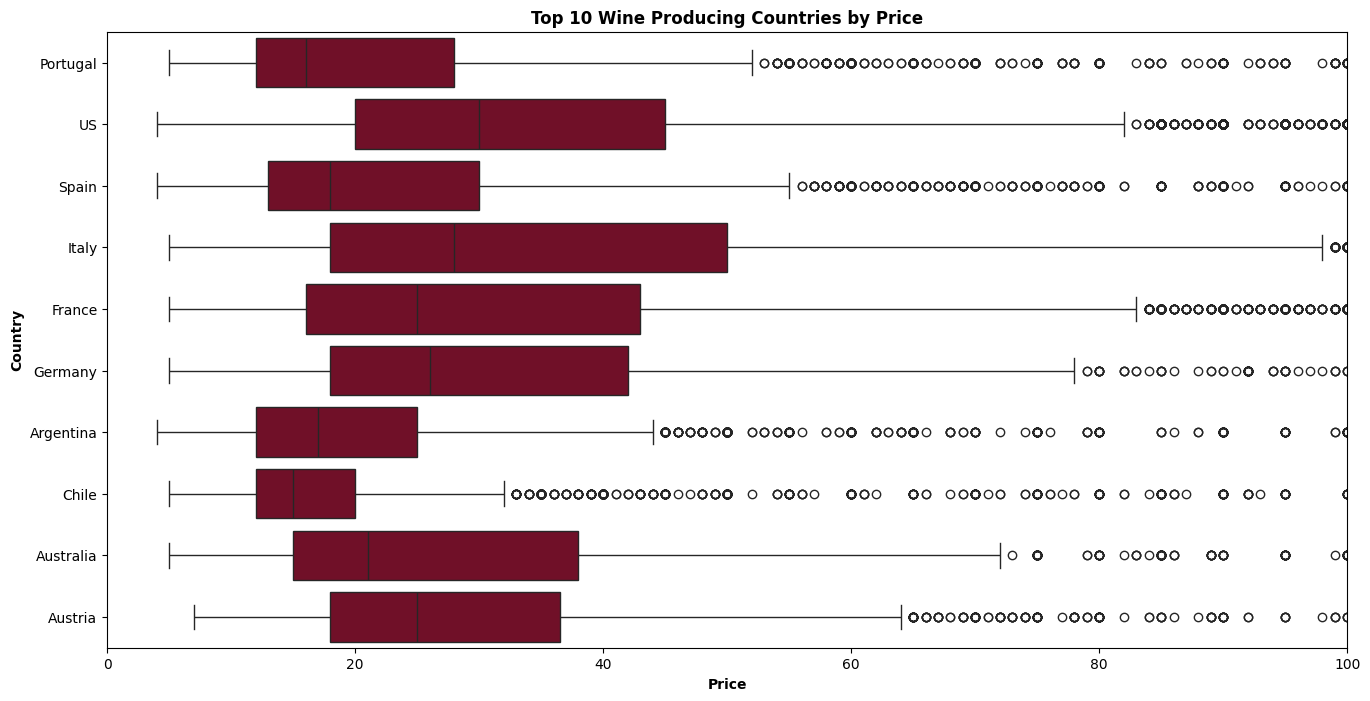

In [18]:
fig, axs = plt.subplots(figsize=(16,8))
box = sns.boxplot(df.loc[df.country.isin(top10countries.index)], x='price', y='country', color='#800020')
box.set_xlim(0,100)

box.set_title('Top 10 Wine Producing Countries by Price').set_fontweight('bold')


box.set_xlabel('Price').set_fontweight('semibold')
box.set_ylabel('Country').set_fontweight('semibold')

plt.show()

Prices of wines from the top 10 producting countries between tend to be concentrated around $20-$30, with the widest range of prices coming out of Italy

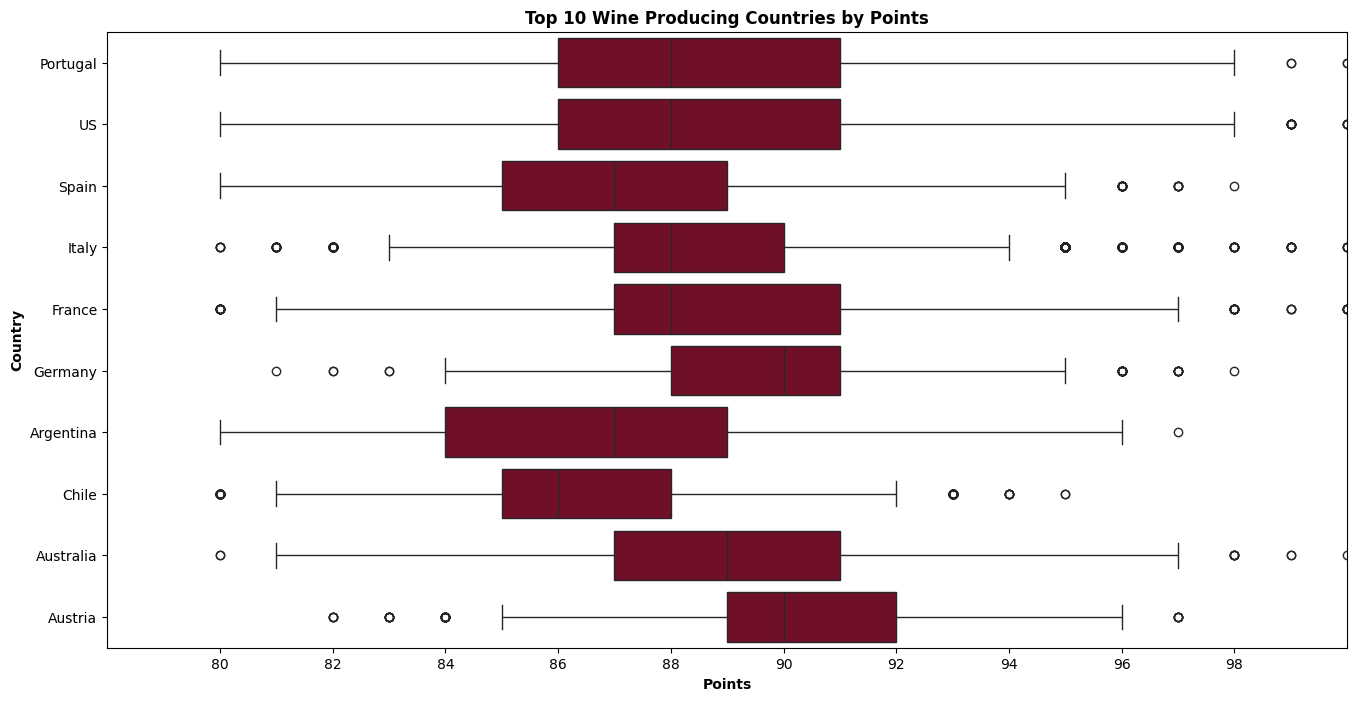

In [19]:
fig, axs = plt.subplots(figsize=(16,8))
box = sns.boxplot(df.loc[df.country.isin(top10countries.index)], x='points', y='country', color='#800020')
box.set_xlim(78,100)
box.set_xticks(range(80, 100, 2))
box.set_title('Top 10 Wine Producing Countries by Points').set_fontweight('bold')


box.set_xlabel('Points').set_fontweight('semibold')
box.set_ylabel('Country').set_fontweight('semibold')

plt.show()

Wines from all top producing countries tend to be scored between 85 and 92 points.

Spanish, Chilean, and Argentinian wines tend to score lower than other top producing countries.
***

## Wines by Variety

In [20]:

# View of top 10 varieties
top10countries = df.country.value_counts().head(10)



top_10_var = df.variety.value_counts().head(10)
top10pct_var = top_10_var.sum() / df.shape[0] * 100
top_variety = df[df['variety'].isin(top_10_var.index)]

print(top_10_var)

print('Top 10 varieties make up {0:.2f}% of the dataset'.format(top10pct_var))

variety
Pinot Noir                  12787
Chardonnay                  11080
Cabernet Sauvignon           9386
Red Blend                    8476
Bordeaux-style Red Blend     5340
Riesling                     4972
Sauvignon Blanc              4783
Syrah                        4086
Rosé                         3262
Merlot                       3062
Name: count, dtype: int64
Top 10 varieties make up 55.58% of the dataset


Wine are much more distributed across variety, though the top 10 varieties account for over half of total reviews. 

Text(0, 0.5, '')

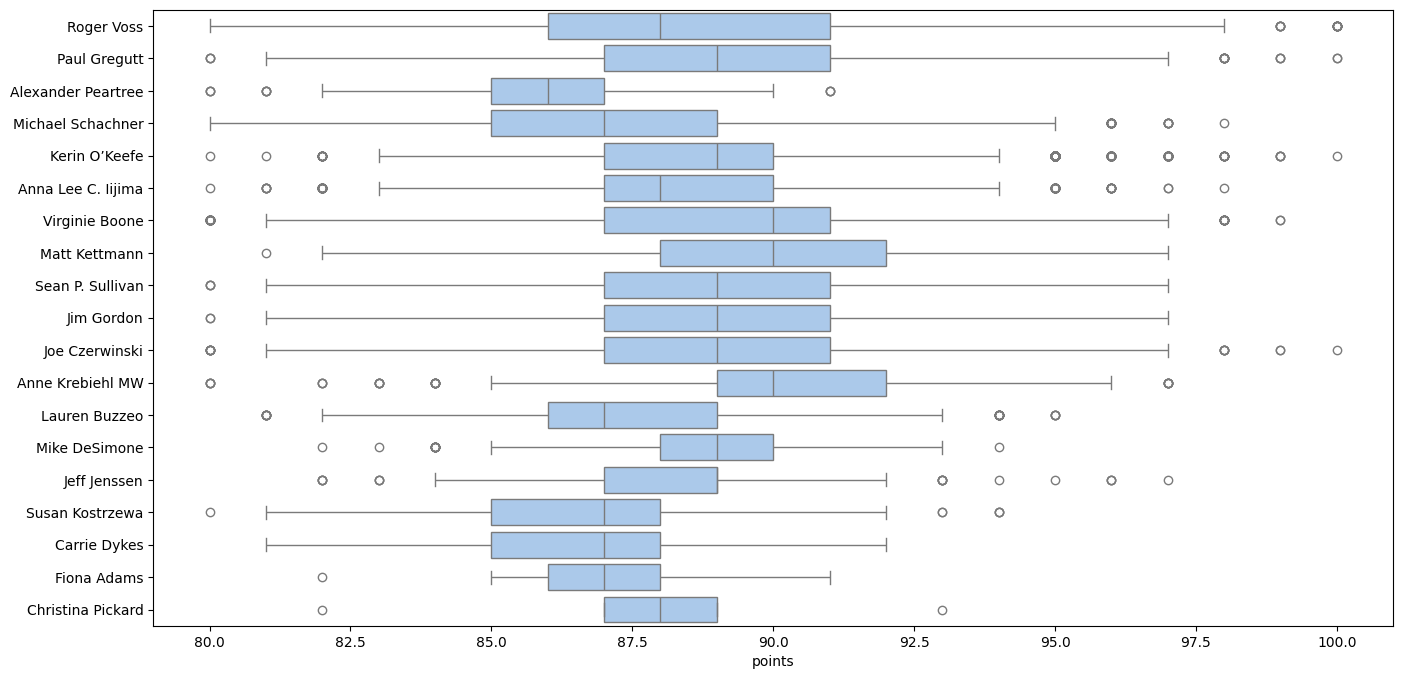

In [21]:
df[['taster_name', 'points','price']].groupby(by='taster_name', axis=0).mean()
plt.subplots(figsize=(16,8))
sns.boxplot(y=df.taster_name, x = df.points, orient='h')
plt.ylabel(None)

All tasters tend to score wines between 85 and 91 points, further analysis of distributions by variety or country of origin may surface biases of preference.

***
## Wines by Vintage

Text(0, 0.5, '')

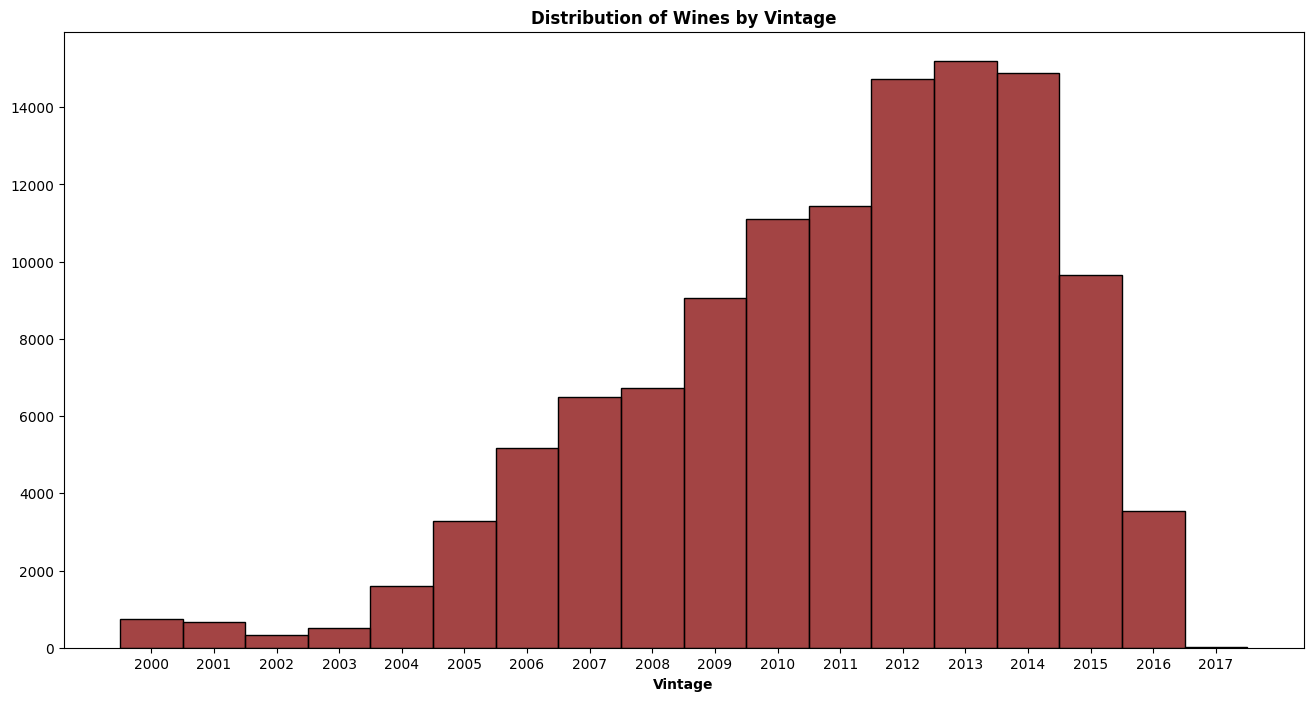

In [22]:
fig, ax = plt.subplots(figsize=(16,8))
plt.title('Distribution of Wines by Vintage').set_fontweight('semibold')
plt.xlabel('Vintage').set_fontweight('semibold')
sns.histplot(df.sort_values('vintage'), x='vintage', color='#850505').set_ylabel('')

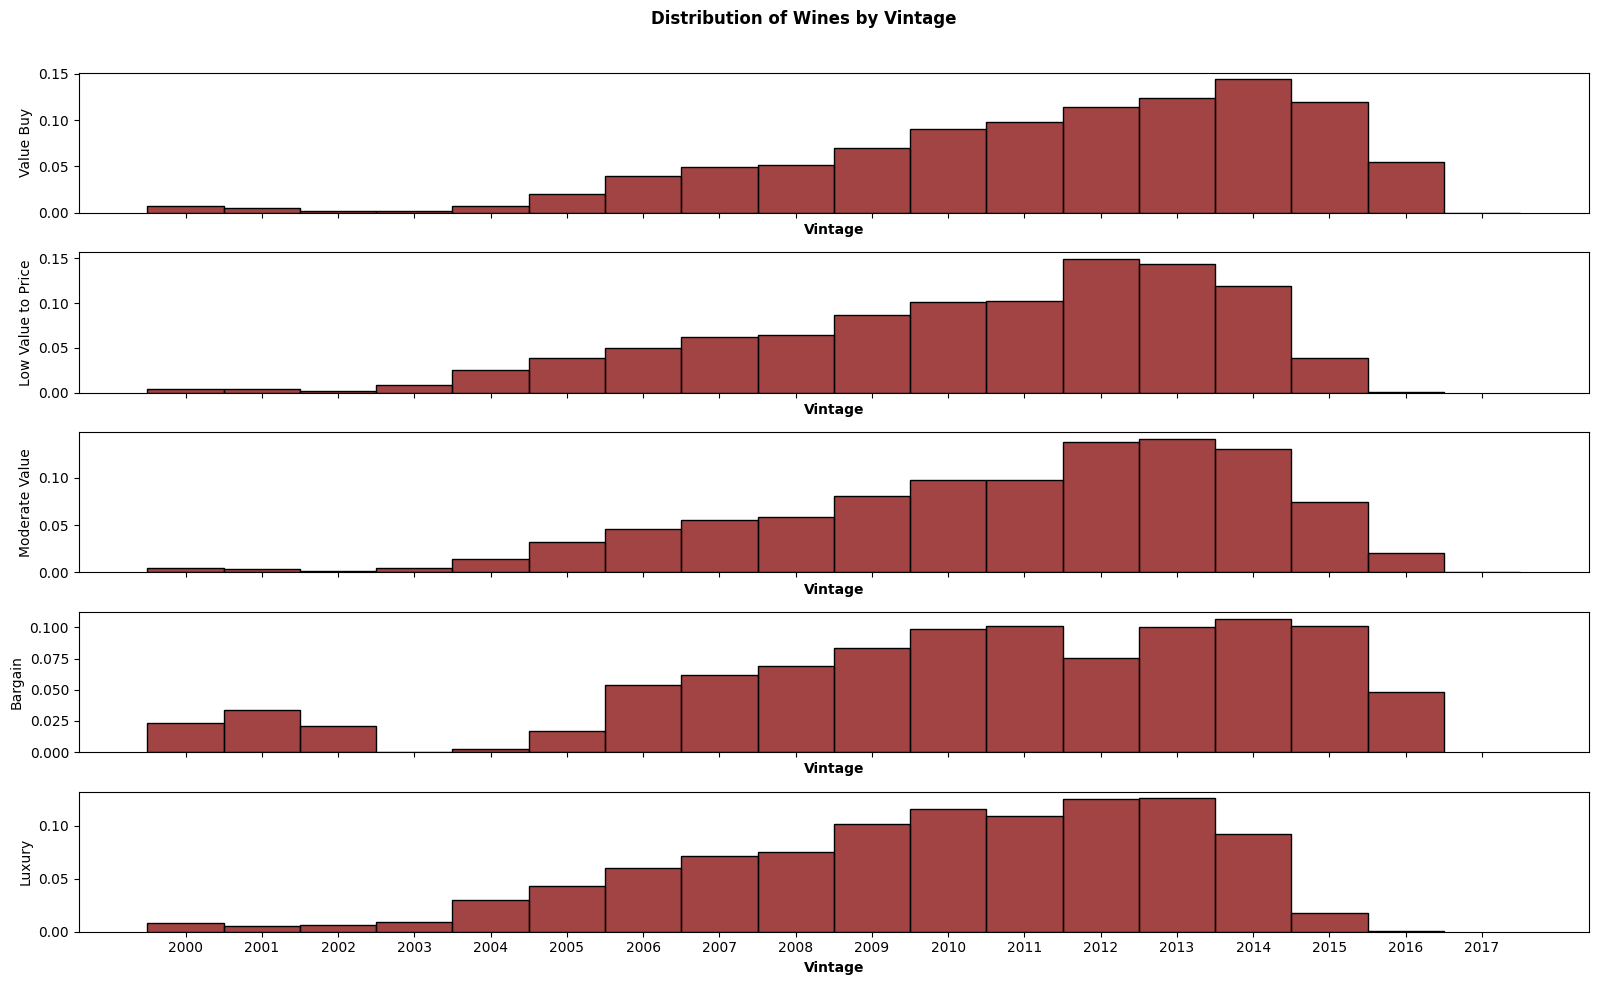

In [23]:

# Get unique value categories, ignoring NaN
value_categories = df.value_category.dropna().unique()
n_categories = len(value_categories)

fig, axs = plt.subplots(nrows=n_categories, figsize=(16, 2*n_categories), sharex=True)
if n_categories == 1:
    axs = [axs]  

fig.suptitle('Distribution of Wines by Vintage', fontweight='semibold')
plt.xlabel('Vintage', fontweight='semibold')

for plot, each in enumerate(value_categories):
    axs[plot].set_xlabel('Vintage', fontweight='semibold')
    sns.histplot(
        df[df['value_category'] == each].sort_values('vintage'),
        x='vintage',
        ax=axs[plot],
        color='#850505',
        stat='density'
    ).set_ylabel(str(each))

fig.tight_layout(rect=[0, 0, 1, 0.97])



We observed above that all wines in the dataset tend to be vintages 2009-2015. Across value categories, we can observe a small shift toward newer vintages for "Value Buy" wines, while all other categories' distributions remained approximately the same. 

The proportion of wines in the "Bargain" (under $10) category from vintages 2000-2002 does seem atypical, as these would be 15+ year old wines at the time the data was obtained. 

In [ ]:
# export dataframes to csv
# df.to_csv('winemag130post.csv', sep=',', header=True)
# subset.to_csv('winemag130-bottom99.csv', sep=',', header=True)